#Imports

In [ ]:
!pip install pygam

In [ ]:
from datetime import datetime
from distutils.util import strtobool
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import seaborn as sns
import pygam
from pygam import GAM, f, s, te, l, intercept
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn import set_config
from sklearn.metrics import mean_squared_error

set_config(transform_output = "pandas")

#Ingest Data

In [ ]:
bitcoin = pd.read_csv("/content/drive/MyDrive/CIVE7100/bitcoinData.csv", index_col = 0)
bitcoin = bitcoin[['google_trends', 'difficulty', 'active_addresses', 'price']]
bitcoin['returns'] = bitcoin['price'].astype('float64') - bitcoin['price'].astype('float64').shift(1)
bitcoin.dropna(inplace = True)
bitcoin.head()

,google_trends,difficulty,active_addresses,price,returns
2014-04-10,13.854,6.119726e+09,182996.0,407.703,-39.407
2014-04-11,12.997,6.119726e+09,169622.0,403.328,-4.375
2014-04-12,9.229,6.119726e+09,132283.0,425.310,21.982
2014-04-13,10.385,6.119726e+09,172708.0,415.876,-9.434
2014-04-14,10.754,6.119726e+09,183291.0,445.898,30.022


In [ ]:
bitcoin['logReturn'] = np.log(bitcoin['price'].astype('float64')/bitcoin['price'].astype('float64').shift(1))
bitcoin.dropna(inplace = True)
bitcoin.drop(['returns', 'price'], axis = 1, inplace = True)
bitcoin.head()

,google_trends,difficulty,active_addresses,logReturn
2014-04-11,12.997,6.119726e+09,169622.0,-0.010789
2014-04-12,9.229,6.119726e+09,132283.0,0.053068
2014-04-13,10.385,6.119726e+09,172708.0,-0.022431
2014-04-14,10.754,6.119726e+09,183291.0,0.069703
2014-04-15,11.053,6.119726e+09,199054.0,0.089541


In [ ]:
bitcoinFeatures = bitcoin.copy()
bitcoinLogReturn = bitcoin['logReturn'].copy()

#MinMax Normalization

In [ ]:
scaler = MinMaxScaler()
bitcoinFeatures = scaler.fit_transform(bitcoinFeatures.drop(['logReturn'], axis = 1))
bitcoinFeatures = pd.concat([bitcoinFeatures, bitcoinLogReturn], axis = 1)
bitcoinFeatures.head()

,google_trends,difficulty,active_addresses,logReturn
2014-04-11,0.012637,0.0,0.051984,-0.010789
2014-04-12,0.006476,0.0,0.017498,0.053068
2014-04-13,0.008367,0.0,0.054834,-0.022431
2014-04-14,0.008970,0.0,0.064609,0.069703
2014-04-15,0.009459,0.0,0.079167,0.089541


# Train Validation Test Split

In [ ]:
bitcoinFeaturesArray = np.array(bitcoinFeatures)
bitcoinLogReturnArray = np.array(bitcoinLogReturn)

trainFeatures = bitcoinFeaturesArray[:-8]
trainTargets = bitcoinLogReturnArray[1:-8 + 1]

testFeatures = bitcoinFeaturesArray[-8:-1]
testTargets = bitcoinLogReturnArray[-8 + 1:]

print(trainFeatures.shape)
print(trainTargets.shape)
print(testFeatures.shape)
print(testTargets.shape)

(2649, 4)
(2649,)
(7, 4)
(7,)


#GAM

In [ ]:
lams = [np.logspace(-2, 2, 5)] * 4
lams

[array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])]

In [ ]:
GAMmodel = GAM(s(0) + s(1) + s(2) + s(3))

# find best fit with training data
GAMmodel.gridsearch(trainFeatures,
                    trainTargets,
                    lam = lams,
                    return_scores = False,
                    keep_best = True,
                    progress = True)

100% (625 of 625) |######################| Elapsed Time: 0:02:05 Time:  0:02:05


GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + intercept, tol=0.0001, 
   verbose=False)

In [ ]:
GAMmodel.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     36.2914
Link Function:                     IdentityLink Log Likelihood:                                -1390116.74
Number of Samples:                         2649 AIC:                                          2780308.0627
                                                AICc:                                         2780309.1567
                                                GCV:                                                 0.001
                                                Scale:                                              0.0009
                                                Pseudo R-Squared:                                   0.1006
Feature Function                  Lam

<ipython-input-9-2503fdf48fa0>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  GAMmodel.summary()


Text(0.5, 1.0, 'Histogram of GAM Residuals')

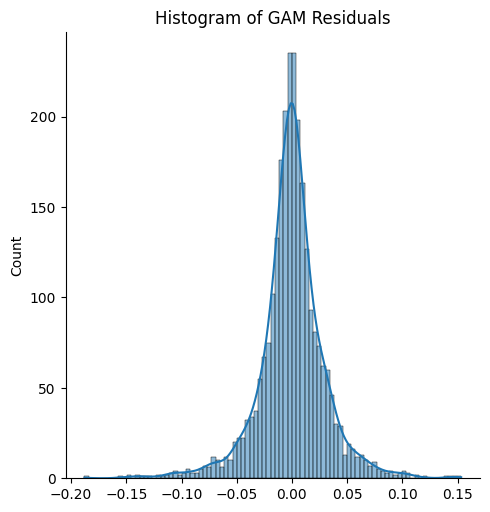

In [ ]:
resid = GAMmodel.deviance_residuals(trainFeatures, trainTargets)
sns.displot(resid, kde = True)
plt.title("Histogram of GAM Residuals")

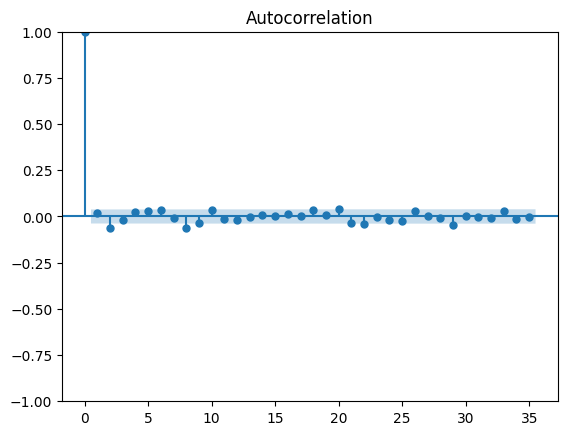

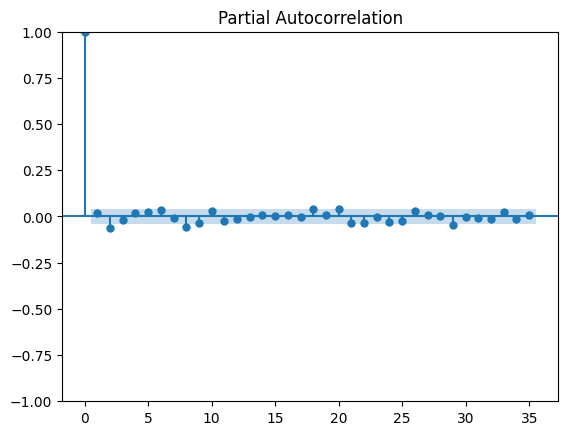

In [ ]:
plot_acf(resid)
plot_pacf(resid)
plt.show()

#Visualize Partial Dependency Plots

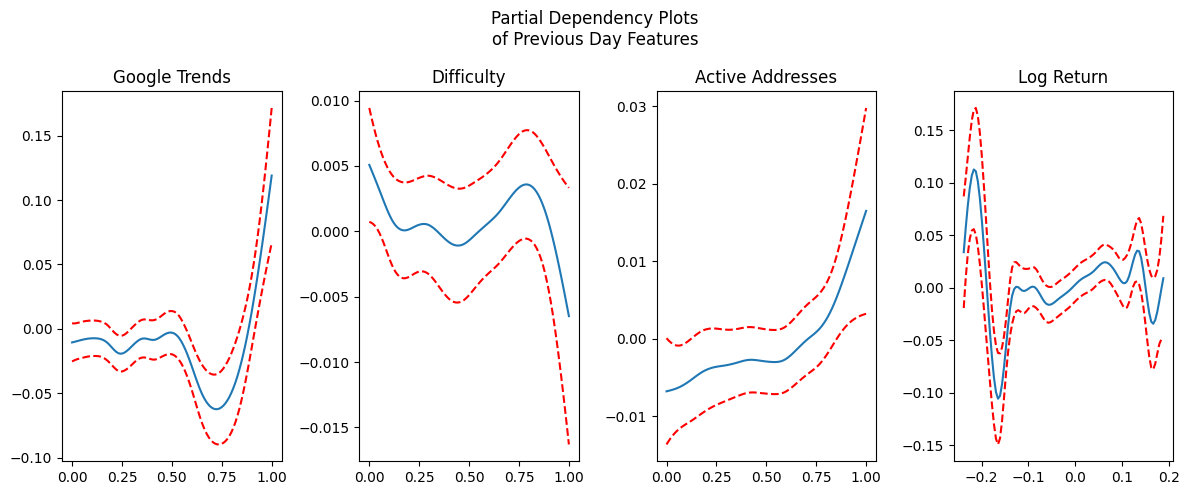

In [ ]:
# 2D
fig, axs = plt.subplots(1, 4, figsize = (12, 5))

titles = ["Google Trends", "Difficulty", "Active Addresses", "Log Return"]
#xlab = ['Points', 'Yards']

for i, ax in enumerate(axs):

  XX = GAMmodel.generate_X_grid(term = i)

  pdep, confi = GAMmodel.partial_dependence(term = i, width=.95)

  ax.plot(XX[:, i], pdep)
  ax.plot(XX[:, i], confi, c='r', ls='--')
  ax.set_title(titles[i])

  if i == 0: ax.set_ylabel("")

plt.suptitle("Partial Dependency Plots\nof Previous Day Features")
plt.tight_layout()

#Eval

In [ ]:
pred = GAMmodel.predict(testFeatures)
print(pred)
print(testTargets)

[-0.00064597 -0.00951977 -0.00451428 -0.00488016 -0.00448609 -0.00208793
  0.00311189]
[-0.02542357 -0.01120237 -0.01176521 -0.01124364 -0.00612898  0.00653835
 -0.03753087]


In [ ]:
RMSE = np.sqrt(mean_squared_error(testTargets, pred))
print(RMSE)

0.018665383785022586


#Plot Test v Pred

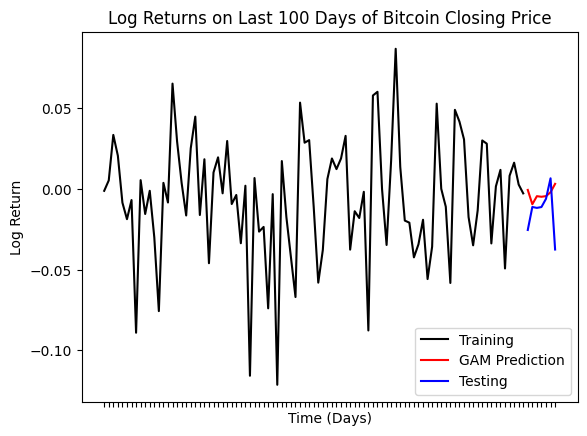

In [ ]:
plt.plot(bitcoin.index[-100:-7], bitcoin.logReturn[-100:-7], color = 'black', label = 'Training')
plt.plot(bitcoin.index[-7:], pred, color = 'red', label = 'GAM Prediction')
plt.plot(bitcoin.index[-7:], testTargets, color = 'blue', label = 'Testing')
#plt.ylim(-0.1, 0.1)
plt.title('Log Returns on Last 100 Days of Bitcoin Closing Price')
plt.ylabel('Log Return')
plt.xlabel('Time (Days)')
plt.tick_params(axis='x',          # changes apply to the x-axis
                which='major',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
plt.legend()